#  A/B Testing Analysis for Cookie Cats Mobile Game  
**Portfolio Case Study**

This project investigates **the impact of moving the first progression gate** in Cookie Cats from level 30 to level 40.  
Using a real A/B test dataset of **90,189 players**, we aim to determine whether this design change  
improves player engagement and retention — two of the most critical drivers of lifetime value.

---

###  Business Context & Analytical Goal

Tactile Entertainment, the developer of Cookie Cats, is experimenting with game design to find the optimal balance between **player experience** and **monetization triggers**.

- A **gate** is a checkpoint that stops player progression until they spend in-game currency, invite friends, or wait a timer.  
- **Control group (gate_30):** Players hit the first gate at level 30.  
- **Treatment group (gate_40):** Players hit it later, at level 40.  

Leadership needs to know whether delaying the gate leads to **higher engagement and retention** — enough to justify rollout despite the delayed monetization event.

**Key Questions**
1. Do players **play more rounds** when the first gate is moved from level 30 to 40?  
2. Does **day-1 and day-7 retention** improve under gate_40?  
3. Are these differences **statistically significant**, or just random noise?  

**Analytical Plan**
- **T-Test:** Compare mean game rounds between gate_30 vs gate_40.  
- **Chi-Square:** Compare retention rates between groups.  
- Translate findings into **clear business recommendations** for game design and rollout.

---

##  Dataset Overview

This analysis uses the **[Cookie Cats A/B Testing Dataset](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats)** from Kaggle.

- **90,189 players** randomly assigned to two groups (gate_30 vs gate_40)
- Captures **early engagement and retention signals** for the first 14 days post-install
- Well-suited for A/B testing and treatment effect measurement

###  Data Dictionary
| Column         | Description |
|----------------|-------------|
| **userid**     | Unique identifier for each player. |
| **version**    | Group assignment: `gate_30` (control) or `gate_40` (treatment). |
| **sum_gamerounds** | Number of game rounds played during the first 14 days after install. |
| **retention_1** | Binary flag (1/0) — did the player return 1 day after install? |
| **retention_7** | Binary flag (1/0) — did the player return 7 days after install? |

---


In [1]:
# --- Environment Setup ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os, warnings
warnings.filterwarnings("ignore")

# Display settings
pd.set_option("display.max_columns", 80)

# Consistent, professional plotting style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 13,
    "axes.labelsize": 11
})


In [2]:
# --- Load Dataset ---
df = pd.read_csv('/content/cookie_cats.csv')

print(f"Dataframe Shape: {len(df):,} rows × {len(df.columns)} columns")
display(df.head(5))  # quick preview of first 5 rows

print("\nInfo:")
print(df.info())


Dataframe Shape: 90,189 rows × 5 columns


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


#  Exploratory Data Analysis (EDA)

Our first step is to perform **data quality checks** and explore the **distribution of key variables**.  
This helps confirm that the experiment groups are balanced, spot potential outliers, and understand player behavior before we run statistical tests.

We'll focus on:
- **Group Split:** Ensure gate_30 vs gate_40 have similar sample sizes.
- **Game Rounds Distribution:** Detect skewness and extreme outliers.
- **Retention Rates:** Compare day-1 and day-7 retention between groups.


In [3]:
# --- Basic Group Split & Summary ---

# Group counts
group_counts = df['version'].value_counts()
print("Player Counts per Group:")
display(group_counts)

# Basic stats for sum_gamerounds by version
summary_stats = df.groupby('version')['sum_gamerounds'].describe()
display(summary_stats)


Player Counts per Group:


,count
version,
gate_40,45489
gate_30,44700


,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


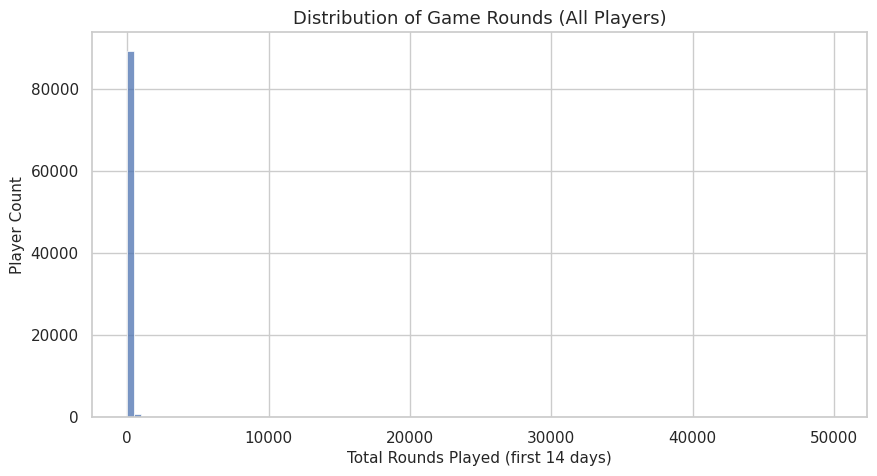

In [4]:
# --- Distribution of Game Rounds ---

plt.figure(figsize=(10,5))
sns.histplot(df['sum_gamerounds'], bins=100, kde=False)
plt.title("Distribution of Game Rounds (All Players)")
plt.xlabel("Total Rounds Played (first 14 days)")
plt.ylabel("Player Count")
#plt.xlim(0, 500)  # limit to 500 for readability (long tail exists)
plt.show()


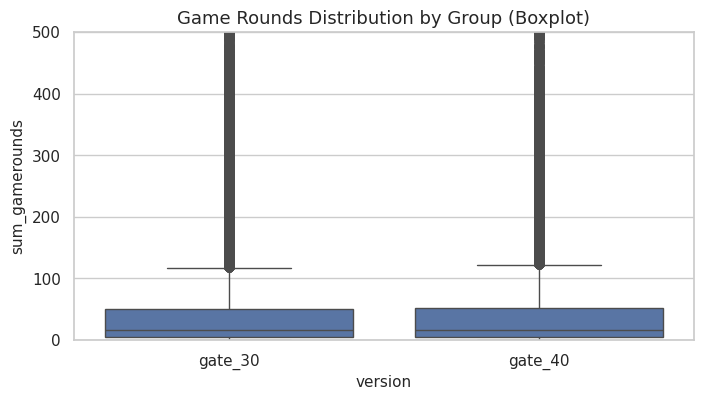

In [5]:
# --- Boxplot to Spot Outliers by Group ---
plt.figure(figsize=(8,4))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title("Game Rounds Distribution by Group (Boxplot)")
plt.ylim(0, 500)  # zoom in to focus on bulk of data
plt.show()


In [6]:
# --- Retention Rates by Group ---
retention_summary = df.groupby('version')[['retention_1','retention_7']].mean().reset_index()
retention_summary[['retention_1','retention_7']] = retention_summary[['retention_1','retention_7']]*100

print("Retention Rates by Group (%):")
display(retention_summary.style.format({'retention_1': "{:.2f}%", 'retention_7': "{:.2f}%"}))


Retention Rates by Group (%):


,version,retention_1,retention_7
0,gate_30,44.82%,19.02%
1,gate_40,44.23%,18.20%


### EDA Observations

**1. Group Balance**  
- **gate_30:** 44,700 players  
- **gate_40:** 45,489 players  
 **Balanced split** — nearly equal player counts, good for A/B testing validity.

---

**2. Game Rounds Distribution**  
- **Mean (gate_30):** 52.46 (but with very high standard deviation, 256.7)  
- **Mean (gate_40):** 51.30 (lower variance, std ≈ 103.3)  
- **Outliers:** gate_30 has a maximum of **49,854 rounds**, much higher than gate_40’s **2,640** — this could be a data artifact or extreme outlier.  
- **Skew:** Distribution is heavily right-skewed — most players play fewer than 100 rounds, with a long tail of very engaged players.  
 **Implication:** The mean may be sensitive to outliers — we might need to confirm robustness (e.g., compare medians or use trimmed means).

---

**3. Retention Rates (Descriptive)**  
| Group | Day-1 Retention | Day-7 Retention |
|------|----------------|----------------|
| **gate_30** | **44.82%** | **19.02%** |
| **gate_40** | 44.23% | 18.20% |

- gate_30 shows slightly higher retention on both day-1 and day-7 (about **0.6% gap on day-1** and **0.8% gap on day-7**).
 **Implication:** These are small differences — we need **chi-square tests** to confirm if they are statistically significant.

---

**4. Next Steps**  
- Consider a **log-transformed visualization** of `sum_gamerounds` to better inspect the distribution’s tail.  
- Proceed with:
  - **T-test:** Compare average `sum_gamerounds` between gate_30 and gate_40.  
  - **Chi-Square:** Test for significance in day-1 and day-7 retention differences.  
- Decide whether to **remove extreme outliers** (like the 49k gameround case) before running tests, as they can distort results.


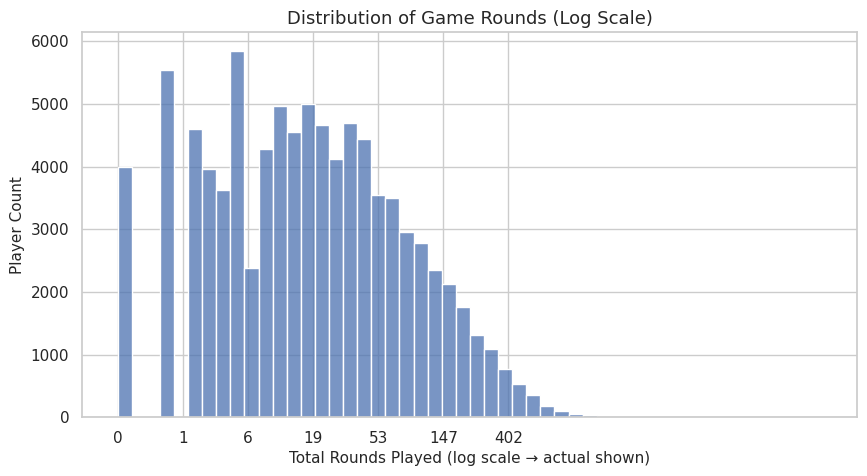

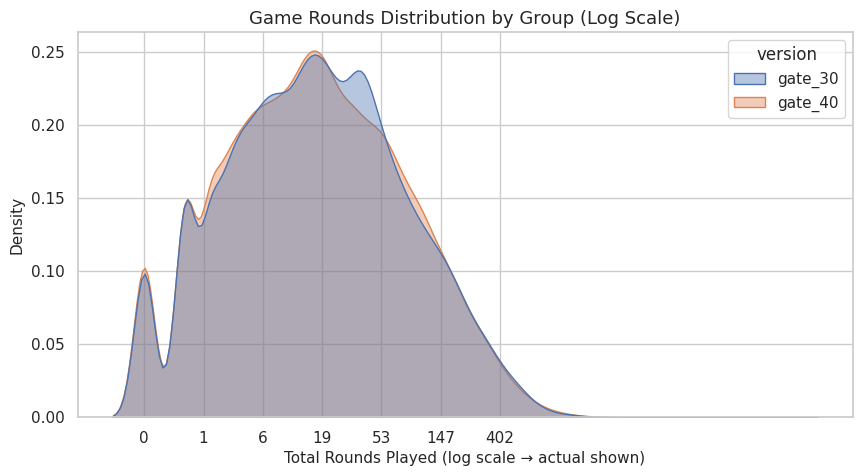

In [7]:
# --- Log-Transformed Distribution of Game Rounds with Readable X-Axis ---

# Add a small constant to avoid log(0)
df['log_gamerounds'] = np.log1p(df['sum_gamerounds'])

# Define nice tick positions and labels (convert log back to actual rounds)
import numpy as np

tick_positions = [0, 1, 2, 3, 4, 5, 6]  # log(1+x) positions
tick_labels = [f"{int(np.expm1(x))}" for x in tick_positions]  # expm1 reverses log1p -> actual rounds

# Histogram
plt.figure(figsize=(10,5))
sns.histplot(df['log_gamerounds'], bins=50, kde=False)
plt.title("Distribution of Game Rounds (Log Scale)")
plt.xlabel("Total Rounds Played (log scale → actual shown)")
plt.ylabel("Player Count")
plt.xticks(tick_positions, tick_labels)
plt.show()

# Density by group
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x='log_gamerounds', hue='version', fill=True, common_norm=False, alpha=0.4)
plt.title("Game Rounds Distribution by Group (Log Scale)")
plt.xlabel("Total Rounds Played (log scale → actual shown)")
plt.ylabel("Density")
plt.xticks(tick_positions, tick_labels)
plt.show()


###  Interpreting the Log-Scale Distributions

**1. Histogram (Log Scale with Actual Round Counts)**  
- The x-axis is displayed in **actual round counts** at key points for easier interpretation.
- Most players play **between 0 and ~50 rounds** in their first 14 days.
- After that, the number of players steadily decreases — confirming a **long-tail engagement pattern**, with a small fraction of highly engaged players playing hundreds or even thousands of rounds.

---

**2. Density Curves by Group**  
- The curves for `gate_30` (blue) and `gate_40` (orange) **almost perfectly overlap** across the entire range.
- This indicates that **moving the gate from level 30 to 40 did not substantially change how many rounds players play overall**.
- Any small differences visible in the curves are very subtle — visual inspection alone is not enough to draw conclusions.

---

**Business Insight:**  
Engagement patterns appear very similar between the two groups, suggesting that moving the first gate later in the game does **not drastically alter play behavior**.  
We will confirm this with **formal statistical tests** (t-test for average rounds played, chi-square for retention rates) to determine whether the observed differences are statistically significant and actionable.


##  Statistical Testing – Player Engagement (T-Test)

Now that we’ve visually explored the distributions, we formally test whether the **average number of rounds played** differs between `gate_30` and `gate_40`.

###  Hypotheses
- **Null (H₀):** Mean rounds played are the same in both groups.
- **Alternative (H₁):** Mean rounds played differ between groups.

### Approach
- **Step 1:** Winsorize (cap) the top 1% of `sum_gamerounds` values to reduce distortion from extreme outliers.
- **Step 2:** Run an **independent samples t-test** (Welch’s t-test) to compare group means.
- **Step 3:** Report the **p-value** — if `p < 0.05`, we reject the null and conclude the difference is statistically significant.


In [8]:
from scipy import stats

# --- Winsorize extreme outliers (cap at 99th percentile) ---
upper_limit = df['sum_gamerounds'].quantile(0.99)
df['winsorized_gamerounds'] = np.where(df['sum_gamerounds'] > upper_limit, upper_limit, df['sum_gamerounds'])

# --- Split data by group ---
g30 = df.loc[df['version'] == 'gate_30', 'winsorized_gamerounds']
g40 = df.loc[df['version'] == 'gate_40', 'winsorized_gamerounds']

# --- Independent samples t-test (Welch’s t-test) ---
t_stat, p_val = stats.ttest_ind(g30, g40, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}")

# Calculate group means for business context
mean_g30 = g30.mean()
mean_g40 = g40.mean()
print(f"\nMean Rounds (gate_30): {mean_g30:.2f}")
print(f"Mean Rounds (gate_40): {mean_g40:.2f}")
print(f"Difference: {mean_g40 - mean_g30:.2f}")


T-statistic: 0.503
P-value: 0.61519

Mean Rounds (gate_30): 49.14
Mean Rounds (gate_40): 48.85
Difference: -0.28


###  Interpretation – Player Engagement (T-Test)

**Results:**
- **Mean Rounds Played**
  - `gate_30`: 49.14 rounds
  - `gate_40`: 48.85 rounds  
  **Difference:** −0.28 rounds (gate_40 slightly lower)

- **T-Test**
  - **t-statistic:** 0.503  
  - **p-value:** 0.615 (> 0.05)

**Conclusion:**
- The difference in average rounds played between the two groups is **very small (less than 1 round)** and **not statistically significant** (`p > 0.05`).
- This means we cannot reject the null hypothesis — **moving the gate from level 30 to 40 does not meaningfully change player engagement**, at least as measured by number of rounds played in the first 14 days.

**Business Insight:**
From an engagement perspective, **delaying the first gate does not increase playtime**.  
Since this change also delays the first monetization opportunity, the design team may not see a strong ROI from rolling out `gate_40` based on engagement alone.  
Retention analysis will provide additional evidence before making a final decision.


##  Retention Analysis – Chi-Square Tests

Retention is a critical KPI for free-to-play games.  
It measures the **percentage of players who return to play after install**, and is a key driver of lifetime value.

We will compare **Day-1** and **Day-7 retention rates** between `gate_30` and `gate_40` to see whether moving the first gate meaningfully affects player stickiness.

###  Hypotheses
For each retention metric (Day-1 and Day-7):
- **Null (H₀):** Retention rate is the same for gate_30 and gate_40.
- **Alternative (H₁):** Retention rate differs between the two groups.

We will use a **Chi-Square test of independence** on a 2×2 contingency table.


In [9]:
from scipy.stats import chi2_contingency
import pandas as pd

# --- Day-1 Retention Chi-Square Test ---

# Build contingency table with percentages
ret1_table = pd.crosstab(df['version'], df['retention_1'])
ret1_table_pct = ret1_table.div(ret1_table.sum(axis=1), axis=0) * 100
ret1_combined = ret1_table.astype(str) + " (" + ret1_table_pct.round(2).astype(str) + "%)"
print("Day-1 Retention Contingency Table (Counts + %):")
display(ret1_combined)

# Run chi-square test
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(ret1_table)
print(f"Chi-Square Statistic (Day-1): {chi2_1:.3f}")
print(f"P-value (Day-1): {p_1:.5f}")

# --- Day-7 Retention Chi-Square Test ---

# Build contingency table with percentages
ret7_table = pd.crosstab(df['version'], df['retention_7'])
ret7_table_pct = ret7_table.div(ret7_table.sum(axis=1), axis=0) * 100
ret7_combined = ret7_table.astype(str) + " (" + ret7_table_pct.round(2).astype(str) + "%)"
print("\nDay-7 Retention Contingency Table (Counts + %):")
display(ret7_combined)

# Run chi-square test
chi2_7, p_7, dof_7, expected_7 = chi2_contingency(ret7_table)
print(f"Chi-Square Statistic (Day-7): {chi2_7:.3f}")
print(f"P-value (Day-7): {p_7:.5f}")


Day-1 Retention Contingency Table (Counts + %):


retention_1,False,True
version,,
gate_30,24666 (55.18%),20034 (44.82%)
gate_40,25370 (55.77%),20119 (44.23%)


Chi-Square Statistic (Day-1): 3.159
P-value (Day-1): 0.07550

Day-7 Retention Contingency Table (Counts + %):


retention_7,False,True
version,,
gate_30,36198 (80.98%),8502 (19.02%)
gate_40,37210 (81.8%),8279 (18.2%)


Chi-Square Statistic (Day-7): 9.959
P-value (Day-7): 0.00160


###  Interpretation – Retention Analysis

**Day-1 Retention**
- **gate_30:** 44.82% (20,034 / 44,700)
- **gate_40:** 44.23% (20,119 / 45,489)
- **Chi-Square:** 3.159  
- **p-value:** 0.075 (> 0.05)

 **Interpretation:**  
The small difference in Day-1 retention is **not statistically significant**.  
We cannot conclude that moving the gate changes early-next-day player behavior.

---

**Day-7 Retention**
- **gate_30:** 19.02% (8,502 / 44,700)
- **gate_40:** 18.20% (8,279 / 45,489)
- **Chi-Square:** 9.959  
- **p-value:** 0.0016 (< 0.05)

 **Interpretation:**  
Day-7 retention is **statistically significantly lower** for `gate_40`.  
Players exposed to the later gate return **less often after a week**, suggesting slightly weaker long-term stickiness.

---

**Business Insight**
- **Engagement (rounds played):** No meaningful difference (t-test p > 0.6).  
- **Retention:** Day-1 unchanged, but Day-7 shows a **significant drop** for `gate_40`.

 **Implication:**  
Moving the first gate from level 30 → 40 **does not improve engagement** and actually **slightly harms long-term retention**.  
From a business perspective, this means:
- **No evidence** that the later gate boosts player LTV *(Lifetime Value – the total revenue a player is expected to generate over their entire time playing the game)*.
- Potential risk of lower monetization due to reduced week-long stickiness.

**Recommendation:**  
Maintain `gate_30` as the default gate placement.  
